In [1]:
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
metro = pd.read_csv('../data/medellin_metro.csv', encoding='latin-1')

# Print out data samples
metro.head().T

,0,1,2,3,4
stop,Bello,Palos verdes,Gardel,Manrique,Las Esmeraldas
line,A,L1,L1,L1,L1
comuna_name,Bello-Comuna 03 ',Manrique ',Manrique ',Manrique ',Manrique '
comuna_index,8,9,9,9,9
macrozona,8,13,13,13,13
municipality,bello,medellin,medellin,medellin,medellin
muni_index,3,1,1,1,1
Lattitude,6.337778,6.330278,6.315833,6.300278,6.290597
Longitude,-75.544444,-75.553611,-75.555417,-75.558472,-75.564258
type,Metro,Bus rapid transit,Bus rapid transit,Bus rapid transit,Bus rapid transit


In [3]:
# Read in the data
comunas_df = pd.read_csv('../data/comunas.csv', 
                         encoding='latin-1')
populat_df = pd.read_csv('../data/comunas_pop.csv', 
                         encoding='latin-1')
stratum_df = pd.read_csv('../data/comunas_stratum.csv', 
                         encoding='latin-1')
firms_df = pd.read_csv('../data/comunas_firms.csv',
                         encoding='latin-1')

# Define tweaking function
def tweak_df(df):
    return (df
     .rename(columns=lambda c: c.strip().lower().replace(' ', '_'))
     .pipe(extract_names)
     .assign(**{c:lambda df_, c=c: (df_[c]
                                     .str.title()
                                     .str.replace('\'', '')
                                     .str.strip())
                for c in columns_object})
     )

# Define other useful functions
def extract_names(df):
    globals()['columns_number'] = df.select_dtypes('number').columns
    globals()['columns_object'] = df.select_dtypes(exclude='number').columns
    return df
    
# Reformat each of the datasets
comunas_df = tweak_df(comunas_df)
populat_df = tweak_df(populat_df)
stratum_df = tweak_df(stratum_df)
firms_df = tweak_df(firms_df)

In [4]:
df = (metro
 .pipe(tweak_df) 
 # appending the shapefile identifier
 .merge(comunas_df,
        how='left',
        on=['comuna_index', 'muni_index', 'comuna_name', 'municipality'])
 # appending population count
 .merge(populat_df,
        how='left',
        on=['comuna_index', 'muni_index'])
 # appending information about stratum
 .merge(stratum_df,
        how='left',
        on=['comuna_index', 'muni_index'])
 # appending number of firms
 .merge(firms_df,
        how='left',
        on=['comuna_index', 'muni_index'])
)

## Understading the spatial distribution of the data

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

sns.set(style='white', rc={'figure.figsize':(16, 12)})

# Read in geographical information
geoms = gpd.read_file('../data/comunas_boundaries.zip')

geoms = (geoms
 .set_index('MACROZONA')
 .merge((df
         .groupby('macrozona')
         .agg({'population':'sum',
               'stratum':'mean',
               'num_firms':'mean'})),
        how='inner',
        left_index=True,
        right_index=True
       )
 .pipe(gpd.GeoDataFrame, geometry='geometry')
)

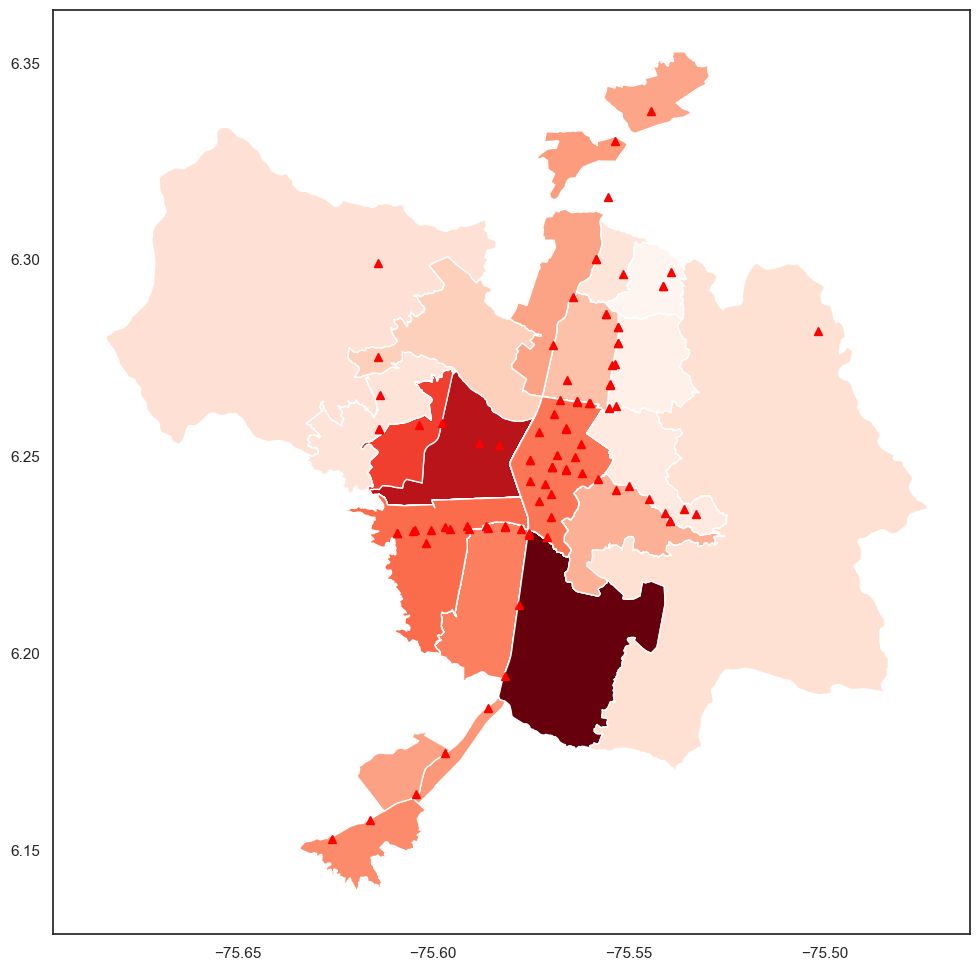

In [47]:
_ = gdf.plot(column='stratum', cmap='Reds')
_ = plt.plot(gdf.longitude.values, 
             gdf.lattitude.values, 
             marker='^', linestyle='none', color='red')

# TODOS
- 